# Validations

### Common Imports

In [3]:
import sys
import os

# root_path = os.path.dirname(os.getcwd())
# src_path = os.path.join(root_path, "src")
# sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

import neptune.new as neptune
from neptune.new.types import File
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTkyYmJiYi0wN2E1LTRkY2YtOWU3Ny1kNjhjYmM3ZTVkNWEifQ=="
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

# Helper functions

In [4]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy
import torch

### Download the checkpoint from Neptune

In [3]:
run = neptune.init(
        project='cellarium/tissue-purifier',
        api_token=NEPTUNE_TOKEN,
        run='TIS-1807',
        mode="read-only")
run["training/model/checkpoints/best_checkpoint-epoch=999.ckpt"].download("ckpt_BARLOW_tis_1807_epoch_999.pt")
run.stop()

https://app.neptune.ai/cellarium/tissue-purifier/e/TIS-1807
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


### check that the files are downloaded

In [4]:
! ls -l ./ckpt*

-rw-r--r-- 1 jupyter jupyter 165097961 Feb  3 20:54 ./ckpt_BARLOW_tis_1807_epoch_999.pt
-rw-r--r-- 1 jupyter jupyter 342805925 Jan 19 21:11 ./ckpt_dino_tis_1583_epoch_291.pt
-rw-r--r-- 1 jupyter jupyter 626084437 Jan 26 14:34 ./ckpt_dino_tis_1722_epoch_999.pt


### load the pretrained models and set it to eval mode

In [5]:
from tissue_purifier.model_utils.barlow import BarlowModel
from tissue_purifier.model_utils.vae import VaeModel
from tissue_purifier.model_utils.dino import DinoModel
from tissue_purifier.model_utils.simclr import SimclrModel

barlow_ckpt = "./ckpt_BARLOW_tis_1807_epoch_999.pt"
barlow = BarlowModel.load_from_checkpoint(checkpoint_path=barlow_ckpt, strict=False)
barlow = barlow.eval()
config = barlow._hparams

### Recreate the dataset using the same parameters used during training

In [6]:
from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM, SlideSeqKidneyDM    

config_for_validation = config.copy()
config_for_validation["n_crops_for_tissue_test"] = 1  # I am going to create the crops on the fly
config_for_validation["n_crops_for_tissue_train"] = 1  # I do not need multiple images
config_for_validation["load_count_matrix"] = True
config_for_validation["batch_size_per_gpu"] = 32 

if config_for_validation["dataset"] == 'slide_seq_testis':
    DM = SlideSeqTestisDM
elif config_for_validation["dataset"] == "slide_seq_kidney":
    DM = SlideSeqKidneyDM    
else:
    raise Exception()

dm = DM(**config_for_validation)
dm.prepare_data()
dm.setup(stage=None)

-----> running datamodule init
-----> running datamodule prepare_data
Will create the test and train file
untar data
number of elements ---> 31659
mean and median spacing 15.622264926052864, 15.420071793081707
The dense shape of the image is -> torch.Size([9, 1178, 1178])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 31649     5]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 31629    15]
number of elements ---> 33059
mean and median spacing 15.358030584634598, 15.508166323067783
The dense shape of the image is -> torch.Size([9, 1180, 855])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 33033    13]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 32973    43]
number of elements ---> 39206
mean and median spacing 15.535967840319682, 15.438280914030202
The dense shape of the image is -> torch.Size([9, 1179, 1180])
Occupacy (ze

### Extract the full size images from the traindata

In [7]:
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset
sp_images = train_dataset.imgs
metadatas = train_dataset.metadatas

f_names = [meta.f_name for meta in metadatas]
cell_to_code_dict = sp_images[0]._categories_to_codes
cell_types = list(cell_to_code_dict.keys())

print()
print("metadatas -->", metadatas)
print()
print("tissue_names -->",f_names)
print()
print("cell_types ---->", cell_types)


metadatas --> [MetadataCropperDataset(f_name='wt1', loc_x=0.0, loc_y=0.0, moran=-99.9), MetadataCropperDataset(f_name='wt2', loc_x=0.0, loc_y=0.0, moran=-99.9), MetadataCropperDataset(f_name='wt3', loc_x=0.0, loc_y=0.0, moran=-99.9), MetadataCropperDataset(f_name='dis1', loc_x=0.0, loc_y=0.0, moran=-99.9), MetadataCropperDataset(f_name='dis2', loc_x=0.0, loc_y=0.0, moran=-99.9), MetadataCropperDataset(f_name='dis3', loc_x=0.0, loc_y=0.0, moran=-99.9)]

tissue_names --> ['wt1', 'wt2', 'wt3', 'dis1', 'dis2', 'dis3']

cell_types ----> ['ES', 'Endothelial', 'Leydig', 'Macrophage', 'Myoid', 'RS', 'SPC', 'SPG', 'Sertoli']


### Visualize one image as a check

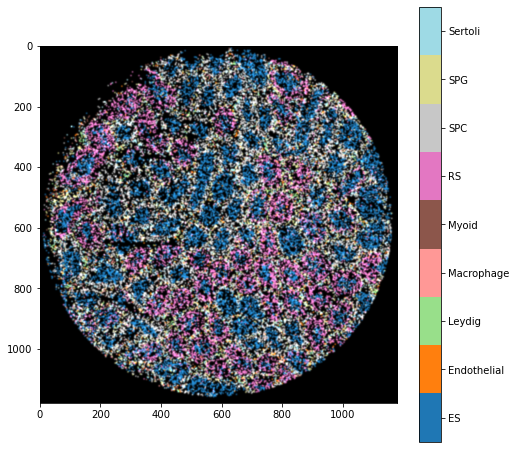

In [8]:
from tissue_purifier.data_utils.transforms import *
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel

dense_img, fig = sp_images[0].to_rgb(cmap='tab20', figsize=(8,8), contrast=1.5)
fig

### Check the anndata object associated with the image

In [9]:
adata = sp_images[0].anndata
adata
# adata.var
# adata.obs
# adata.X

AnnData object with n_obs × n_vars = 31659 × 24450
    obs: 'x', 'y', 'cell_type'

# 0. Start neptune expoeriment for logging

In [10]:
logging_mode = "offline" # "async" # "offline" # or "async"
run: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_TOKEN,
                                    mode=logging_mode,
                                    tags=["validation_testis_dataset", "v0"])

offline/e9772164-0050-4632-a3a5-2d0781d3d412
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# 1. Analyze sparse images by tiling them with patches

In [7]:
from tissue_purifier.misc_utils.dict_util import inspect_dict
from tissue_purifier.model_utils.analyzer import SpatialAutocorrelation, Composition

for sp_img in sp_images:
    sp_img.clear_patch_and_image_properties()

In [12]:
# These first set of analyzer work on images. Note that transform is NOT none
analyzers = [
    barlow.cuda(),
    #vae.cuda(),
    #dino.cuda(),
]

feature_names= [
    "feature_barlow",
    #"feature_vae",
    #"feature_dino",
]

N_patches_max = 600 # start small for debugging purpose

print("I am going to apply this transform --->")
print(dm.trsfm_test)

for sp_img, f_name in zip(sp_images, f_names):
    sp_img.analyze_with_tiling(
        cropper=dm.cropper_test,
        transform=dm.trsfm_test,  # makes dense_imgs from sparse_imgs
        patch_analyzers=analyzers,
        feature_names=feature_names,
        batch_size=64,
        n_patches_max=N_patches_max,
        overwrite=True,
        store_crops=True)  
    sp_img.patch_properties_dict['classify_tissue_label'] = [f_name] * N_patches_max

I am going to apply this transform --->
Before stack -> Compose(
    DropoutSparseTensor(p=0.5, dropouts=((0.1, 0.2, 0.3))
    SparseToDense
    Rasterize(normalize=False, sigmas=((0.5, 1.0)))
    RandomVFlip(pflip=0.5)
    RandomHFlip(pflip=0.5)
    RandomGlobalIntensity(f_min=0.8, f_max=1.2)
). After stack -> CenterCrop(size=(96, 96))
I will generate 600 new patches for this sparse image
I will generate 600 new patches for this sparse image
I will generate 600 new patches for this sparse image
I will generate 600 new patches for this sparse image
I will generate 600 new patches for this sparse image
I will generate 600 new patches for this sparse image


In [13]:
# These second set of analyzer work on sparse tensor. Note that transform is NONE.
analyzers = [
    Composition(return_fraction=True), 
    Composition(return_fraction=False), 
    SpatialAutocorrelation(modality='moran', n_neighbours=6, neigh_correct=True),
]

feature_names= [
    "feature_composition", 
    "feature_cell_number", 
    "moran_I",
]

for sp_img, f_name in zip(sp_images, f_names):
    sp_img.analyze_with_tiling(
        cropper=dm.cropper_test,
        transform=None,
        patch_analyzers=analyzers,
        feature_names=feature_names,
        batch_size=64,
        n_patches_max=N_patches_max,
        overwrite=True)    

I will reuse the 600 patches previously generated for this sparse image
I will reuse the 600 patches previously generated for this sparse image
I will reuse the 600 patches previously generated for this sparse image
I will reuse the 600 patches previously generated for this sparse image
I will reuse the 600 patches previously generated for this sparse image
I will reuse the 600 patches previously generated for this sparse image


In [15]:
# torch.save((sp_images, metadatas ), "./sp_images_valut.pt")

In [8]:
sp_images, metadatas = torch.load("./sp_images_valut.pt", map_location=torch.device('cpu'))

# 2. Add a new variable to patch dictionary properties

In [9]:
for sp_img in sp_images:
    sp_img.patch_properties_dict["regress_moran"] = torch.max(sp_img.patch_properties_dict["moran_I"], axis=-1)[0]
    
inspect_dict(sp_images[0].patch_properties_dict)

 feature_barlow <class 'torch.Tensor'> torch.Size([600, 512]) cpu
 image_patches <class 'torch.Tensor'> torch.Size([600, 9, 96, 96]) cpu
 patch_xywh <class 'torch.Tensor'> torch.Size([600, 4]) cpu
 classify_tissue_label <class 'list'> 600
 feature_composition <class 'torch.Tensor'> torch.Size([600, 9]) cpu
 feature_cell_number <class 'torch.Tensor'> torch.Size([600, 9]) cpu
 moran_I <class 'torch.Tensor'> torch.Size([600, 9]) cpu
 regress_moran <class 'torch.Tensor'> torch.Size([600]) cpu


# 3. Transfer the annotations to the image and then the spot

In [10]:
for sp_img in sp_images:
    # add a quantity to the patch_dict
    sp_img.patch_properties_dict["regress_moran"] = torch.max(sp_img.patch_properties_dict["moran_I"], axis=-1)[0]
    
    # transfer from patch to images
    sp_img.patch_property_to_image_property(
        keys_to_transfer=["feature_barlow", "feature_composition", "feature_cell_number", "regress_moran"],
        keys_after_transfer=["feature_barlow_closest", "feature_composition_closest", 
                             "feature_cell_number_closest", "regress_moran_closest"],
        overwrite=True,        
        strategy = "closest")
    
    # transfer from image to spot
    sp_img.image_property_to_spot_property(
        keys_to_transfer=["feature_barlow_closest", "feature_composition_closest", 
                          "feature_cell_number_closest", "regress_moran_closest"],
        overwrite=True,        
        strategy = "closest")

### Check the image dictionary

In [11]:
inspect_dict(sp_images[0].image_properties_dict)

 feature_barlow_closest <class 'torch.Tensor'> torch.Size([512, 1178, 1178]) cpu
 feature_composition_closest <class 'torch.Tensor'> torch.Size([9, 1178, 1178]) cpu
 feature_cell_number_closest <class 'torch.Tensor'> torch.Size([9, 1178, 1178]) cpu
 regress_moran_closest <class 'torch.Tensor'> torch.Size([1, 1178, 1178]) cpu


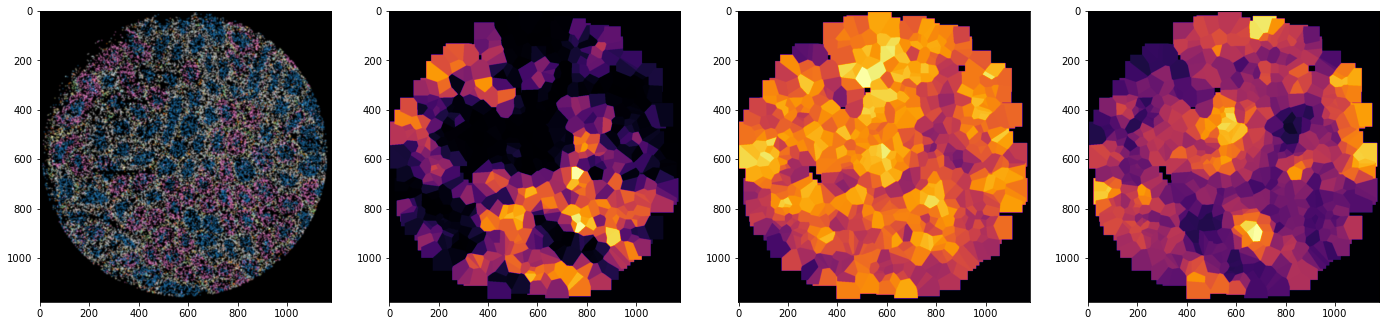

In [12]:
image_rgb = sp_images[0].to_rgb()[0].permute(1,2,0)
image_composition= sp_images[0].image_properties_dict["feature_composition_closest"]
image_barlow = sp_images[0].image_properties_dict["feature_barlow_closest"]
image_moran = sp_images[0].image_properties_dict["regress_moran_closest"]

fig, axes = plt.subplots(ncols=4, figsize=(24,8))
_ = axes[0].imshow(image_rgb)
_ = axes[1].imshow(image_barlow[1], cmap='inferno')
_ = axes[2].imshow(image_moran[0], cmap='inferno')
_ = axes[3].imshow(image_composition[0], cmap='inferno')

### Check the spot dictionary and export to anndata

In [13]:
inspect_dict(sp_images[0].spot_properties_dict)

 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)
 feature_barlow_closest <class 'torch.Tensor'> torch.Size([31659, 512]) cpu
 feature_composition_closest <class 'torch.Tensor'> torch.Size([31659, 9]) cpu
 feature_cell_number_closest <class 'torch.Tensor'> torch.Size([31659, 9]) cpu
 regress_moran_closest <class 'torch.Tensor'> torch.Size([31659, 1]) cpu


In [14]:
adatas = [sp_img.to_anndata() for sp_img in sp_images]

In [17]:
for n, adata in enumerate(adatas):
    adata.write(filename='adata_'+str(n)+".h5ad")

# 4. Gene regression following scanpy tutorial

## Follow scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [ ]:
anndatas_original[0]

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
anndatas_tmp = [adata_tmp.copy() for adata_tmp in anndatas_original]
adata = anndatas_tmp[0]  # start working on a single 

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### add cell and gene id (for scatter plots). Annotate mitocondria.

In [ ]:
adata.obs["cell_id"] = numpy.arange(adata.shape[0])
adata.var["gene_id"] = numpy.arange(adata.shape[1])

print(adata.var_names)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### For each gene check the number of cells 

In [ ]:
print(adata.var['n_cells_by_counts'].describe())  # the 25% percentile is a good place to filter
adata.var['log1p_n_cells_by_counts'] = numpy.log1p(adata.var['n_cells_by_counts'].to_numpy())
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
_ = seaborn.violinplot(y=adata.var['n_cells_by_counts'], ax=axes[1])
_ = seaborn.violinplot(y=adata.var['log1p_n_cells_by_counts'], ax=axes[2])
sc.pl.scatter(adata, x='gene_id', y='n_cells_by_counts', ax=axes[0])

### For each cell check the number of genes 

In [ ]:
print(adata.obs['n_genes_by_counts'].describe())  # the 25% percentile is a good place to filter
adata.obs['log1p_n_genes_by_counts'] = numpy.log1p(adata.obs['n_genes_by_counts'].to_numpy())
fig, axes = plt.subplots(ncols=4, figsize=(16,4))
_ = seaborn.violinplot(y=adata.obs['n_genes_by_counts'], ax=axes[1])
_ = seaborn.violinplot(y=adata.obs['log1p_n_genes_by_counts'], ax=axes[2])
sc.pl.scatter(adata, x='cell_id', y='n_genes_by_counts', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[3], show=True)

### Mitocondria check

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
_ = seaborn.violinplot(y=adata.obs['pct_counts_mt'], ax=axes[1])
_ = sc.pl.scatter(adata, x='cell_id', y='pct_counts_mt', ax=axes[0], show=False)
_ = sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[2], show=True)

### Filtering. (Why filter out cells with many genes? Doublet?)

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.pct_counts_mt < 5, :]  # you do not want cells with too much MT in it.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]  # you do not want to cells with too many genes in it. Why?

### Normalize the counts per beads

Total-count normalize (library-size correct) the data matrix 𝐗 to 500 reads per cell, so that counts become comparable among cells.

In [ ]:
sc.pp.normalize_total(adata, target_sum=500)
print(adata.X.sum(axis=-1))
print(adata.X.sum(axis=-1).shape)

### Log transform the data

In [ ]:
sc.pp.log1p(adata)

### Highly variable genes

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata

### Filter and keep only the highly variable genes

In [ ]:
adata = adata[:, adata.var.highly_variable]

### What is this?

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

### Scale each gene to unit variance

In [ ]:
sc.pp.scale(adata, max_value=10)

### PCA

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca(adata, color='cell_type')


In [ ]:
results_file = './pre_processed_adata.h5ad' 
adata.write(results_file)

### Neighbouring graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# This is just to give nice starting position for umap to plot 
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.umap(adata) 

In [ ]:
sc.tl.leiden(adata)

numpy.argmax(adata.obsm["leiden_feature_dino_res_0.1_one_hot"], axis=-1)### Write the micro_environments into obs so that we can plot in umap

In [ ]:
micro_labels_01 = numpy.argmax(adata.obsm["leiden_feature_dino_res_0.1_one_hot"], axis=-1)
micro_labels_005 = numpy.argmax(adata.obsm["leiden_feature_dino_res_0.05_one_hot"], axis=-1)

adata.obs["micro_labels_res_0.1"] = pandas.Categorical(micro_labels_01)
adata.obs["micro_labels_res_0.05"] = pandas.Categorical(micro_labels_005)

for key in ["leiden_feature_dino_res_0.05_one_hot", "leiden_feature_dino_res_0.1_one_hot"]:
    value = adata.obsm[key]
    n_env = value.shape[-1]
    for n in range(n_env):
        adata.obs['microenv_'+key+'_'+str(n)] = value[:,n] 

## analysis with few structural cluster

In [ ]:
sc.pl.umap(adata, color=['cell_type', 
                         'leiden', 
                         'micro_labels_res_0.05',
                         'microenv_leiden_feature_dino_res_0.05_one_hot_0',
                         'microenv_leiden_feature_dino_res_0.05_one_hot_1'], ncols=3)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

l1 = adata.obs["leiden"].to_numpy()
l2 = adata.obs["cell_type"].to_numpy()
l3 =  adata.obs["micro_labels_res_0.05"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

### Subset

In [ ]:
adata_ES = adata[adata.obs['cell_type'] == 'ES']

l1 = adata_ES.obs["leiden"].to_numpy()
l2 = adata_ES.obs["cell_type"].to_numpy()
l3 =  adata_ES.obs["micro_labels_res_0.05"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

sc.pl.umap(adata_ES, color=['leiden', 'cell_type', 
                            'micro_labels_res_0.05', 'microenv_leiden_feature_dino_res_0.05_one_hot_0'])

## analysis with many structural clusters

In [ ]:
sc.pl.umap(adata, color=['cell_type', 
                         'leiden', 
                         'micro_labels_res_0.1',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_0',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_1',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_2',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_3',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_4'], ncols=3)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

l1 = adata.obs["leiden"].to_numpy()
l2 = adata.obs["cell_type"].to_numpy()
l3 =  adata.obs["micro_labels_res_0.1"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

### Subset

In [ ]:
adata_ES = adata[adata.obs['cell_type'] == 'ES']

l1 = adata_ES.obs["leiden"].to_numpy()
l2 = adata_ES.obs["cell_type"].to_numpy()
l3 =  adata_ES.obs["micro_labels_res_0.1"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

sc.pl.umap(adata_ES, color=['leiden', 'cell_type', 'micro_labels_res_0.1',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_0',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_1',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_2',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_3',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_4'], ncols=3)

In [ ]:
# This is crazy. I would expect cluster by cell_types and then gradient by micro-environment.
# Is this because slide-seq is not really single cell?

### Try to linearly predict the gene expression 

read this:
1. https://medium.com/leukemiaairesearch/a-complete-guide-to-linear-regression-using-gene-expression-data-fit-and-algorithm-evaluation-d73e39b2eb8f
2. https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html

# IDEA
red cell in mask vs red cells in ~maks
nc cell types
k clusters

nc * k matrix similarity 

1.
n_trial = 100
pick cell type i
pick cluster k

delta_ik = 0
for i_trial in range(n_trial):
   pick three patches, two labeled as k (p, +), one labeled as not k (-)
   calculate total gene expression of cell type i in each patch and normalize <-- x^(p)_g, x^(+)_g, x^(-)_g
   calculate delta_ik += (cossim(x^(p)_g, x^(+)_g) - cossim(x^(p)_g, x^(-)_g))
delta_ik /= n_trial

If delta_ik is large for a certain ik and k is enriched in disease then i has role in disease.

3. 
I can do classification with noisy label to obtain disease label
Do as above but delta_ic where c is condition not cluster.
If delta_ic is large, then i has role in disease.


2.
for all beads in cluster k
compute the composition vector cv_{i,k} i=identity of central bead, k=cluster 
(average the composition vector of all macrophage in cluster 7)
same but compute composition vector of the neighbourhood (small nearest neighbour, 25).
(maybe aggregat
calculate delta_ik += (cossim(cv^(p), cv^(+)) - cossim(cv^(p), cv^(-)))

3.
one matrix for each cluter, size of matrix is cell_type by cell_type
count_occurances_of_cell_type_ij_beeing within 5 nearest neighbour of each other in a given cluster (properly normalize)
heat_maps
compare cluster specific heat maps vs cluster agnostic heat maps vs tissue heat_map

after you split the tissue do you get two half with lower/higher contact probabilities....

4. 
predict gene expression conditioned on cell type and cluster label vs predict gene expression conditioned on cell type only.
How much variance can you "explain away" by knowing the cluster label?

5. 
Mutual information between cluster_label, cell_type, gene_expression



In [ ]:
plt.imshow(rgb * (cluster_labels != 0)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 1)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 2)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 3)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 4)[..., None])

In [ ]:
2

In [ ]:
plt.imshow(cluster_labels)

In [ ]:
plt.imshow(overlaid)

In [ ]:
f_names

In [ ]:
n_col = 3
n_row = 2
fig, axes = plt.subplots(ncols=n_col, nrows=n_row, figsize=(12,12))
for n, (f_name, overlaid) in enumerate(zip(f_names, overlaids)):
    c = n % n_col
    r = n // n_col
    ax_curr = axes[r, c]
    _ = ax_curr.imshow(overlaid)
    ax_curr.set_title(f_name)
    
fig.tight_layout()
plt.close(fig)
fig
